In [1]:
import os 
import random
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm
from package.utils import (absolute,
                           merge_dataframe,
                           infile_concat,
                           normalization)
from package.vad_filter import feature_generation
from package.smoothing import total_turn_taking, turn_taking, smoothing
from package.clf import (logistic_regression,
                         random_forest,
                         neural_network,
                         gradient_boosting,
                         LDA,
                         voting_classifier,
                         AUC, 
                         Accuracy, 
                         Sensitivity,
                         Specificity,
                         result)
from package.vis import *

In [2]:
path = "../origin_data/"

In [3]:
random.seed(921)

In [19]:
datalist = os.listdir(path)
datalist = [file for file in datalist if '.xlsx' in file] # path 경로에서 .xlsx 가 있는 파일만 불러와서 datalist에 담기

filename = []
for file in tqdm(datalist) :
    file = file.replace(".xlsx", "") # datalist 에 불러온 파일명에서 .xlsx 지우기 
    
    # 데이터 프레임 이름을 파일 이름으로 지정 
    globals()['df_{}'.format(file)] = pd.read_excel(path + "{}.xlsx".format(file), encoding = 'cp949')
    
    # 파일에 있는 컬럼 중에서 사용할 컬럼만 지정 
    globals()['df_{}'.format(file)] = globals()['df_{}'.format(file)][['#1_snd', '#2_snd', '#3_snd', '#1_talking', '#2_talking', '#3_talking']]
    
    # 지정한 컬럼 이름을 변경 
    globals()['df_{}'.format(file)].columns = ['x1','x2','x3','y1','y2','y3'] 
    filename.append('df_' + file)

100%|██████████| 60/60 [00:42<00:00,  1.41it/s]


In [20]:
# 위의 전처리 (정규화, 절댓값, x1x2x3 / y1y2y3 세로로 이어주기) 를 마친 파일을 p_filename 에 담아준다.
p_filename = []
for f in filename : 
    df = globals()[f]
    norm_df = normalization(df)
    abs_df = absolute(norm_df)
    concat_df = infile_concat(abs_df)
    globals()['p_{}'.format(f)] = concat_df # p_df = preprocessed data
    p_filename.append('p_' + f)

In [21]:
# 모든 시나리오 파일에 대해 파생변수 생성하여 complete_filename에 담는다. 
complete_filename = []
for f in tqdm(p_filename) : 
    df = globals()[f]
    comp_df = feature_generation(df)
    globals()['comp_{}'.format(f)] = comp_df # comp_ =complete
    complete_filename.append('comp_' + f)

100%|██████████| 60/60 [00:03<00:00, 15.87it/s]


In [22]:
# 신호측정이 이상한 파일 제거 :
# 총 60개의 파일 중에서 10개의 파일이 이상함
# 50개의 시나리오 파일만 활용할 예정
## 10개의 파일을 제거한 50개의 파일을 clearfile에 담는다. 

bad_file = ['comp_p_df_12th_short_01', 'comp_p_df_14th_turn_02', 'comp_p_df_15th_turn_01', 
            'comp_p_df_15th_turn_02', 'comp_p_df_3rd_short_01', 'comp_p_df_6th_turn_02', 
            'comp_p_df_7th_short_01', 'comp_p_df_7th_turn_01', 'comp_p_df_9th_turn_01', 
            'comp_p_df_9th_turn_02']

clearfile = complete_filename.copy()
clearfile = [x for x in clearfile if x not in bad_file]

In [23]:
short = [file for file in clearfile if 'short' in file]
t1 = [file for file in clearfile if 'turn_01' in file]
t2 = [file for file in clearfile if 'turn_02' in file]
t3 = [file for file in clearfile if 'turn_03' in file]

In [24]:
print("shrot : {} \n turn_01 : {} \n turn_02 : {} \n turn_03 : {}".format(len(short), len(t1), len(t2), len(t3)))

shrot : 12 
 turn_01 : 12 
 turn_02 : 11 
 turn_03 : 15


In [25]:
# 램덤하게 시나리오 순서를 돌려준다. 
random.shuffle(short) 
random.shuffle(t1)
random.shuffle(t2)
random.shuffle(t3)

data = []
sett = [[9,8,8,10],[3,4,3,5]]
# sett = [[test], [train1], [train2], [train3]] 의 구성을 의미. 각각의 대괄호 안의 숫자는 순서대로 short, turn01, turn02, turn03 의 시나리오의 개수를 의미함. 
## ex. [1, 2, 1, 1] --> short 시나리오: 1개, turn1 시나리오: 2개, turn2 시나리오: 1개, turn3 시나리오: 1개 

# 아래 s1, s2, s3, s4는 각각 [1,5,3,3], [2,2,4,4], [1,3,3,4], [1,5,5,4]를 의미 
## ex. s1 는 test, train1, train2, train3 각각의 첫 번 째 숫자를 의미 (short 시나리오 개수)
for s1,s2,s3,s4 in sett:
    fold = []
    for i in range(s1): # s1 = [1,5,3,3] 이므로 loop를 돌면서 short 시나리오를 1개, 5개, 3개, 3개를 뽑아서 fold에 저장  
        fold.append(short.pop()) # pop 을 씀으로써, 뽑은 시나리오는 삭제한다. 
    for i in range(s2):
        fold.append(t1.pop())
    for i in range(s3):
        fold.append(t2.pop())
    for i in range(s4):
        fold.append(t3.pop())
    data.append(fold)

In [26]:
train = merge_dataframe(globals(), data[0]) # 위의 [9,8,8,10] 데이터를 하나로 이어줌.
test = merge_dataframe(globals(), data[1])    # 위의 [3,4,3,5] test

In [27]:
## Train X, Y
### 위의 train_1, train_2, train_3, test 의 시그널 (x = 26개의 변수) 부분과, 발화 여부 (y = 0 or 1) 부분으로 나눠준다.  
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1]
## Test X, Y 
test_x = test.iloc[:, 1:-1]
test_y = test.iloc[:, -1]

print(train_x.shape)
print(test_x.shape)

train_tuple = (train_x, train_y)

(972393, 26)
(414363, 26)


In [28]:
temp = pd.DataFrame(test_y).reset_index(drop=True)
temp.columns = ['new_smth']
true_test = temp.copy()

### logistic

In [ ]:
lr_sm_pred, lr_origin = logistic_regression(train_tuple, test_x, mode='train')

In [ ]:
ttt = total_turn_taking(lr_sm_pred, true_test)

In [16]:
ttt

,turn_taking
train,125
true_test,122


In [17]:
result(true_test,lr_sm_pred)

,result
AUC,0.904308
Accuracy,0.904725
Sensitivity,0.892734
Specificity,0.915882


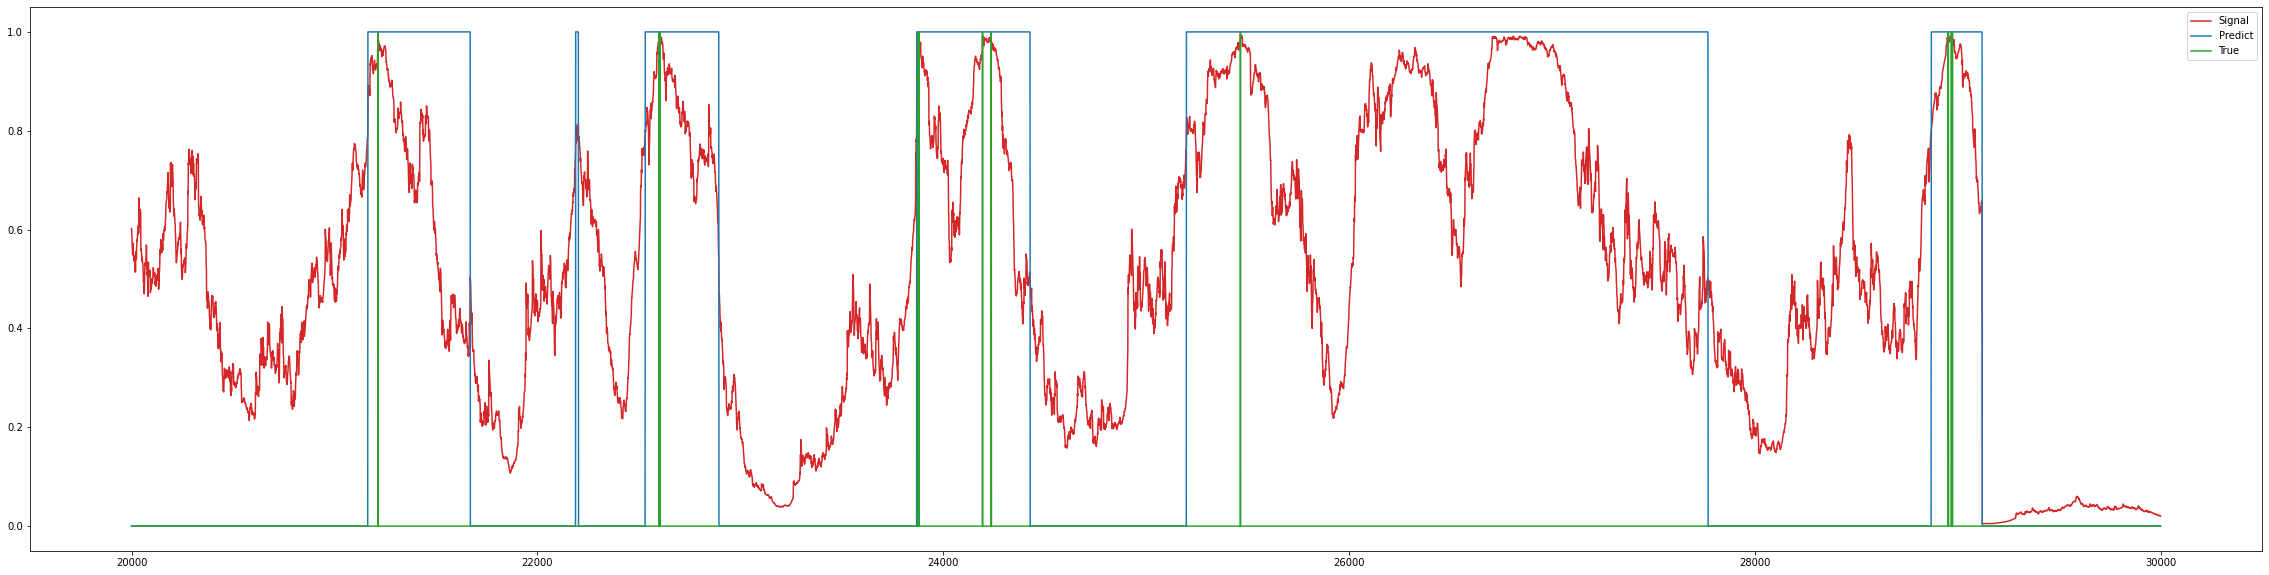

In [18]:
final_graph(20000, 30000, lr_origin, lr_sm_pred, true_test)

### Random forest

In [19]:
rf_sm_pred, rf_origin = random_forest(train_tuple, test_x, mode='train')

100%|██████████| 403431/403431 [02:37<00:00, 2559.21it/s]


In [20]:
ttt_rf = total_turn_taking(rf_sm_pred, true_test)

In [21]:
ttt_rf

,turn_taking
train,124
true_test,122


In [22]:
result(true_test,rf_sm_pred)

,result
AUC,0.919485
Accuracy,0.918318
Sensitivity,0.951895
Specificity,0.887075


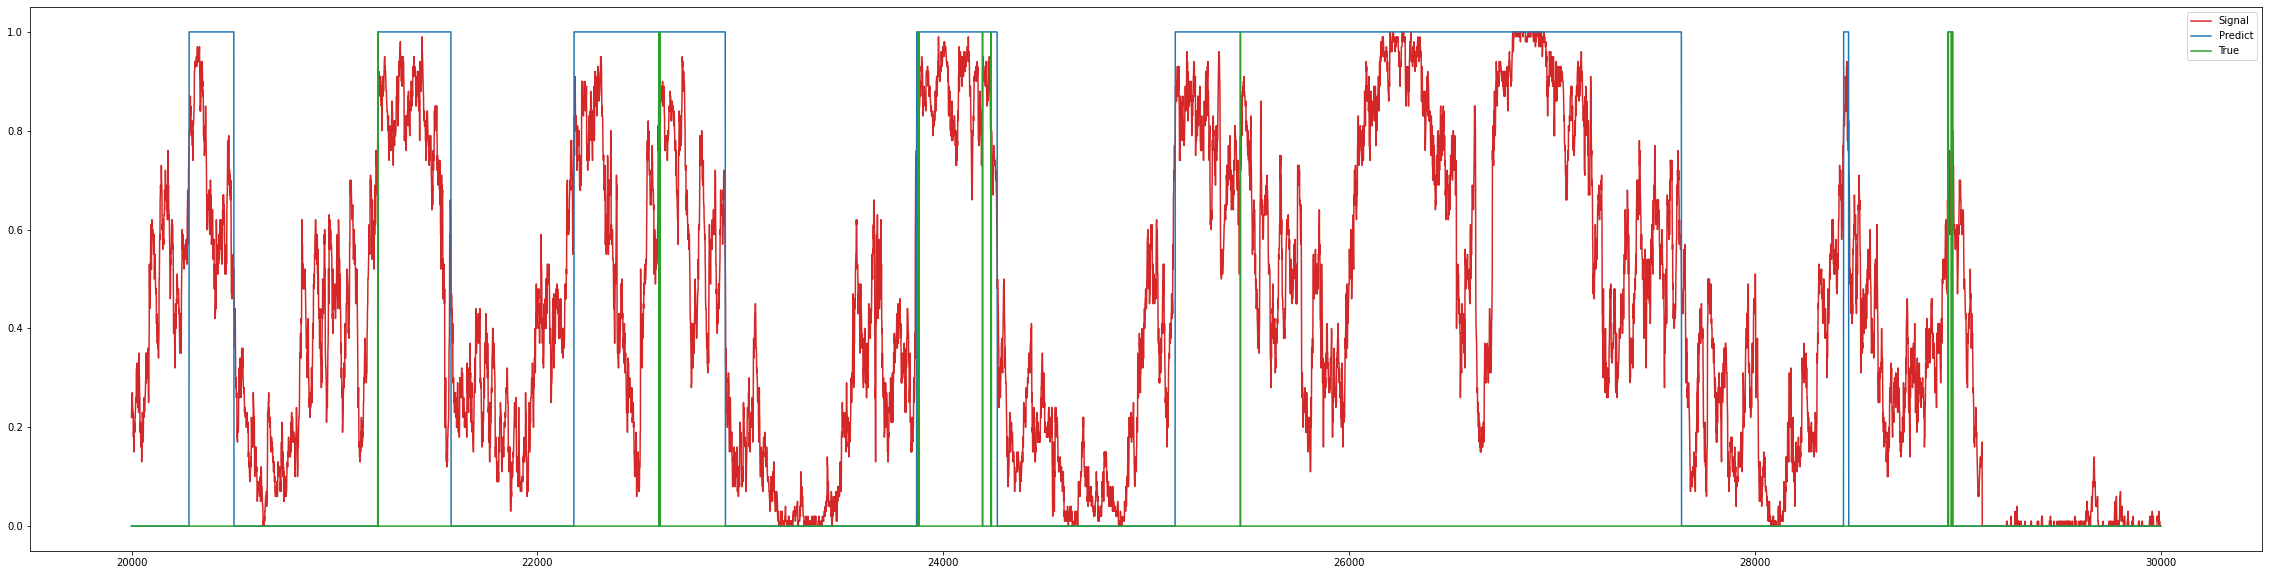

In [23]:
final_graph(20000, 30000, rf_origin, rf_sm_pred, true_test)

### Neural Networks

In [46]:
nn_sm_pred, nn_origin= neural_network(train_tuple, test_x, mode='train')

100%|██████████| 414363/414363 [02:40<00:00, 2578.61it/s]


In [47]:
nn_sm_pred, nn_origin= neural_network(train_tuple, test_x)

100%|██████████| 414363/414363 [02:44<00:00, 2526.50it/s]


In [48]:
ttf_nn = total_turn_taking(nn_sm_pred, true_test)
ttf_nn

,turn_taking
train,125
true_test,137


In [49]:
result(true_test, nn_sm_pred)

,result
AUC,0.914789
Accuracy,0.914681
Sensitivity,0.916883
Specificity,0.912695


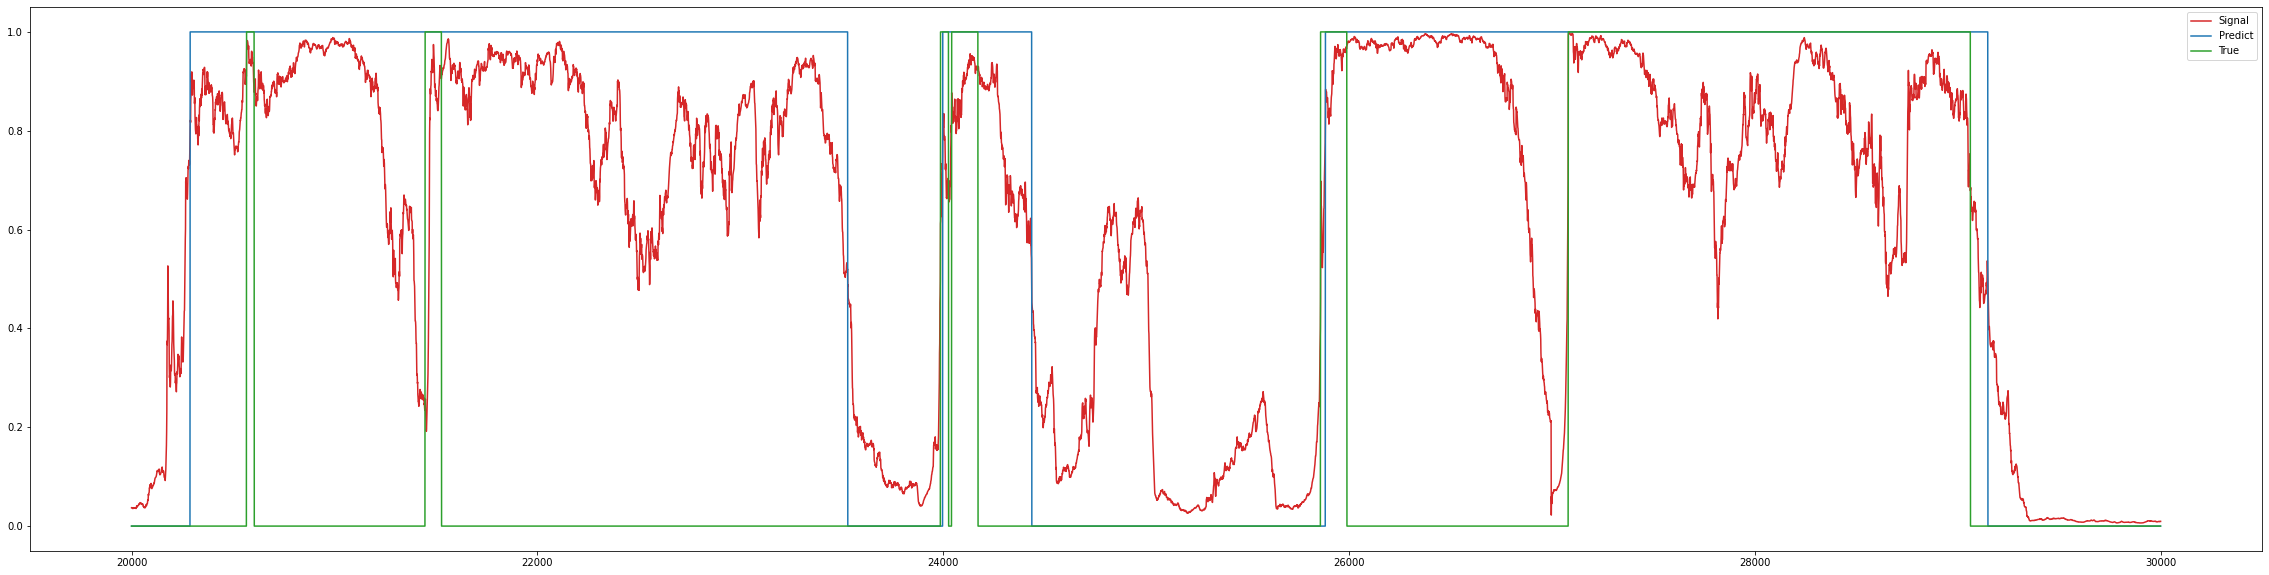

In [50]:
final_graph(20000, 30000, nn_origin, nn_sm_pred, true_test)

### Gradient Boosting

In [14]:
grb_sm_pred, grb_origin= gradient_boosting(train_tuple, test_x, mode='train')

100%|██████████| 403431/403431 [02:33<00:00, 2634.02it/s]


In [15]:
ttf_grb = total_turn_taking(grb_sm_pred, true_test)
ttf_grb

,turn_taking
train,131
true_test,122


In [16]:
result(true_test, grb_sm_pred)

,result
AUC,0.920040
Accuracy,0.919999
Sensitivity,0.921199
Specificity,0.918882


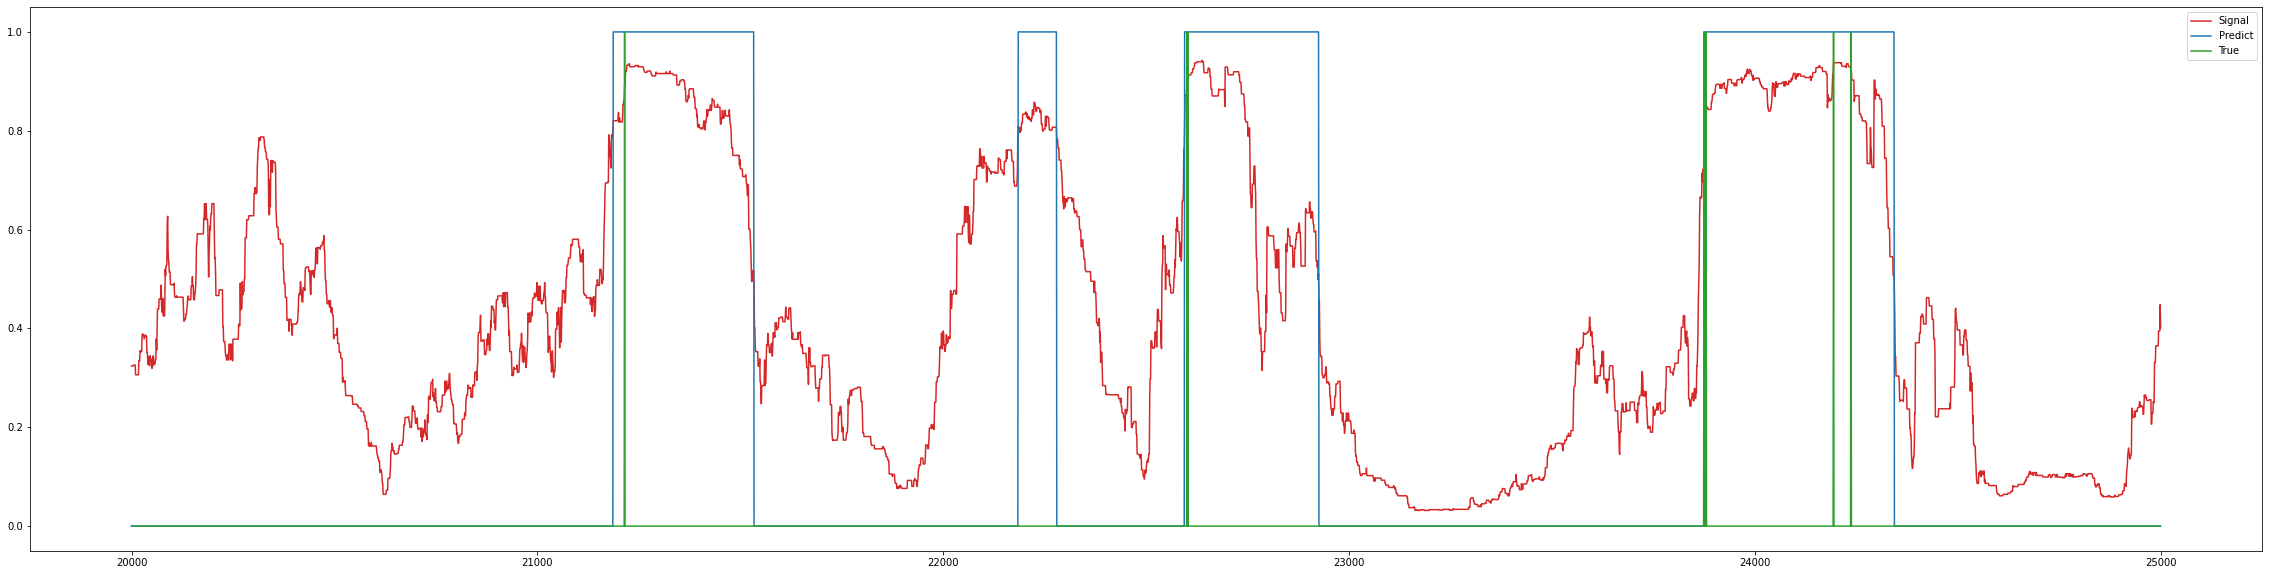

In [17]:
final_graph(20000, 25000, grb_origin, grb_sm_pred, true_test)

### LightGBM

In [29]:
from package.clf import lightGBM

In [31]:
lgb_sm_pred, lgb_origin = lightGBM(train_tuple, test_x, mode='train')

100%|██████████| 414363/414363 [02:38<00:00, 2614.61it/s]


In [33]:
ttf_voting = total_turn_taking(lgb_sm_pred, true_test)
ttf_voting

,turn_taking
train,124
true_test,137


In [34]:
result(true_test, lgb_sm_pred)

,result
AUC,0.922346
Accuracy,0.922088
Sensitivity,0.927361
Specificity,0.917331


### Voting classifier

In [14]:
voting_sm_pred, voting_origin = voting_classifier(train_tuple, test_x, mode='train')

100%|██████████| 403431/403431 [02:45<00:00, 2434.60it/s]


In [15]:
ttf_voting = total_turn_taking(voting_sm_pred, true_test)
ttf_voting

,turn_taking
train,126
true_test,122


In [16]:
result(true_test, voting_sm_pred)

,result
AUC,0.917427
Accuracy,0.917470
Sensitivity,0.916226
Specificity,0.918629


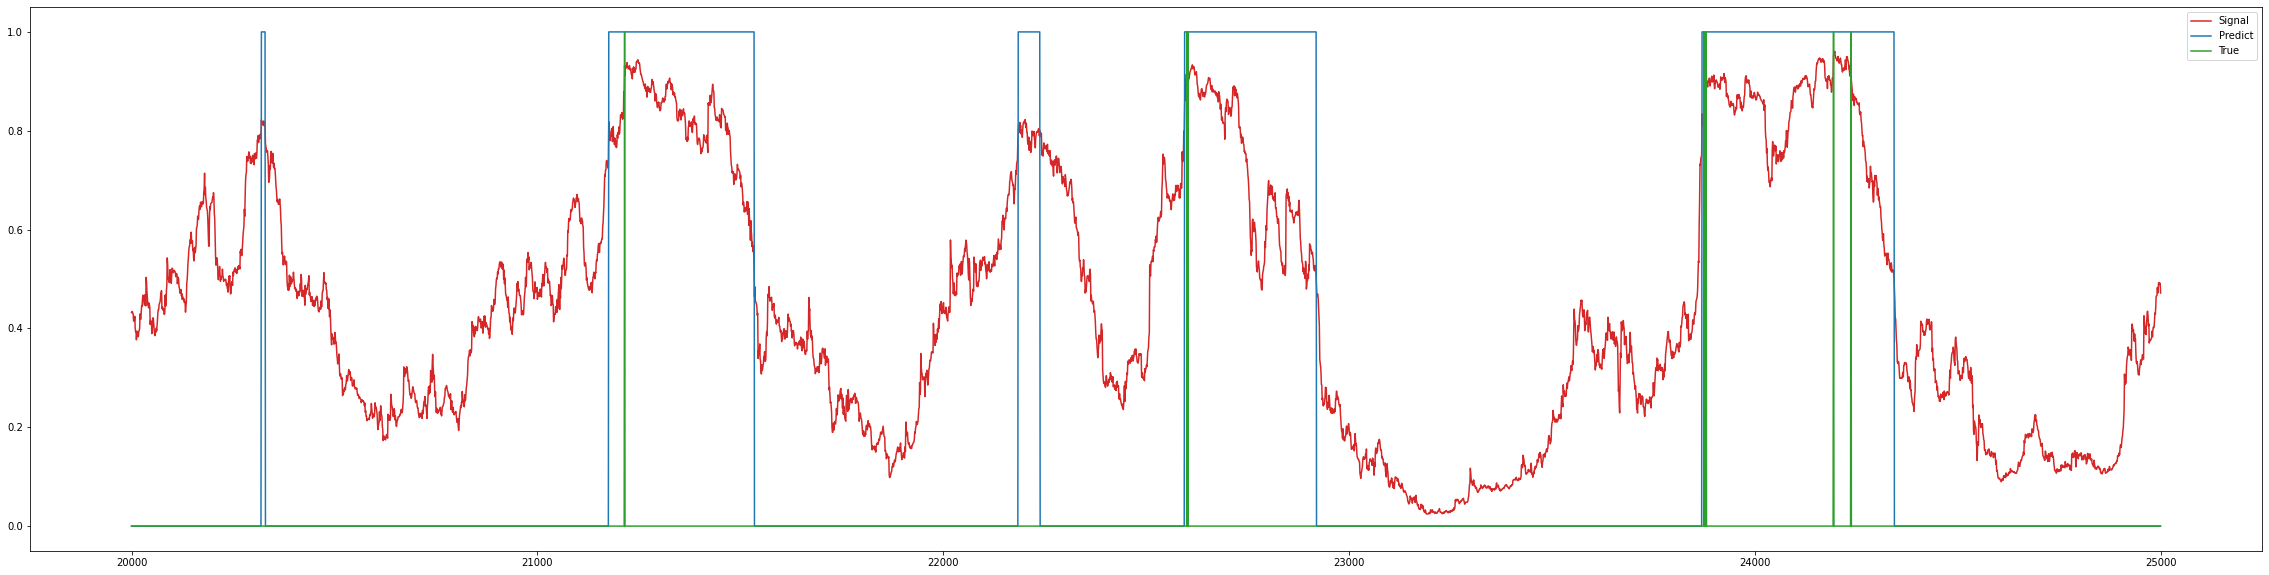

In [17]:
final_graph(20000, 25000, voting_origin, voting_sm_pred, true_test)

## 새로운 테스트셋

In [36]:
## 새로운 테스트셋 불러옴
new_test = pd.read_csv("./new_data/edit_test.csv")

In [37]:
## 새로운 테스트셋 필요없는 변수 정리 및 이름변경
new_test = new_test[['t1_AMP', 't2_AMP', 't3_AMP', 't1_VAD', 't2_VAD', 't3_VAD']]
new_test.columns = ['x1', 'x2', 'x3', 'y1', 'y2', 'y3']
new_test

,x1,x2,x3,y1,y2,y3
0,2026,2107,2034,0,0,0.0
1,2047,2051,2042,0,0,0.0
2,2037,2013,2044,0,0,0.0
3,2035,2039,2041,0,0,0.0
4,2012,2019,2043,0,0,0.0
...,...,...,...,...,...,...
22380,2027,2040,2036,0,0,0.0
22381,2040,2042,2035,0,0,0.0
22382,2081,2053,2046,0,0,0.0
22383,2046,2042,2049,0,0,0.0


In [38]:
#normalization
norm_new = normalization(new_test)
#절대값 취하기
abs_new = absolute(norm_new)
# 각 시나리오 file 별로 x1, x2, x3와 y1,y2,y3를 행단위로 이어준다. 
concat_new = infile_concat(abs_new)

In [39]:
concat_new

,person,signal,talking
0,1.0,0.208610,0.0
1,1.0,0.000151,0.0
2,1.0,0.099259,0.0
3,1.0,0.119141,0.0
4,1.0,0.347784,0.0
...,...,...,...
67150,3.0,0.300160,0.0
67151,3.0,0.324791,0.0
67152,3.0,0.053844,0.0
67153,3.0,0.020051,0.0


In [40]:
feat_new = feature_generation(concat_new)
feat_new

,person,signal,ga10,ga50,ga100,ga200,ga300,sa10,sa50,sa100,...,ma50,ma100,ma200,ma300,sd10,sd50,sd100,sd200,sd300,talking
0,1.0,0.208610,0.121107,0.101677,0.092682,0.140234,0.310320,0.167943,0.099439,-0.080665,...,0.208610,0.208610,0.208610,0.208610,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.000151,0.122707,0.101476,0.092667,0.140380,0.310475,0.154233,0.098994,-0.074337,...,0.104380,0.104380,0.104380,0.104380,0.147403,0.147403,0.147403,0.147403,0.147403,0.0
2,1.0,0.099259,0.132612,0.101081,0.092638,0.140699,0.310777,0.140524,0.098550,-0.068009,...,0.102673,0.102673,0.102673,0.102673,0.104272,0.104272,0.104272,0.104272,0.104272,0.0
3,1.0,0.119141,0.148086,0.100507,0.092592,0.141185,0.311233,0.126815,0.098105,-0.061681,...,0.106790,0.106790,0.106790,0.106790,0.085535,0.085535,0.085535,0.085535,0.085535,0.0
4,1.0,0.347784,0.153152,0.099773,0.092528,0.141830,0.311827,0.113106,0.097661,-0.055353,...,0.154989,0.154989,0.154989,0.154989,0.130778,0.130778,0.130778,0.130778,0.130778,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67150,3.0,0.300160,0.183760,0.156555,0.149668,0.148661,0.155732,0.170713,0.154107,0.132500,...,0.143046,0.160317,0.178991,0.183264,0.094660,0.101351,0.121599,0.145850,0.156977,0.0
67151,3.0,0.324791,0.181867,0.157012,0.149764,0.148637,0.155706,0.171660,0.154533,0.131946,...,0.146987,0.163026,0.178791,0.183757,0.104604,0.104525,0.122219,0.145620,0.157189,0.0
67152,3.0,0.053844,0.172718,0.157367,0.149835,0.148618,0.155685,0.172608,0.154959,0.131393,...,0.147480,0.157854,0.178713,0.183675,0.110369,0.104015,0.115537,0.145683,0.157251,0.0
67153,3.0,0.020051,0.168418,0.157609,0.149885,0.148607,0.155672,0.173556,0.155385,0.130840,...,0.142061,0.156531,0.178668,0.183182,0.116681,0.103442,0.116355,0.145731,0.157532,0.0


In [41]:
new_test_x = feat_new.iloc[:,1:-1]
new_test_y = feat_new.iloc[:, -1]

In [42]:
new_true = pd.DataFrame(new_test_y).reset_index(drop=True)
new_true.columns= ['new_smth']
true_new = new_true.copy()

### Logistic regression

In [26]:
new_lr_sm_pred, new_lr_origin = logistic_regression(train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:23<00:00, 2821.74it/s]


In [27]:
new_turn = total_turn_taking(new_lr_sm_pred,  true_new)

In [28]:
new_turn

,turn_taking
train,36
true_test,45


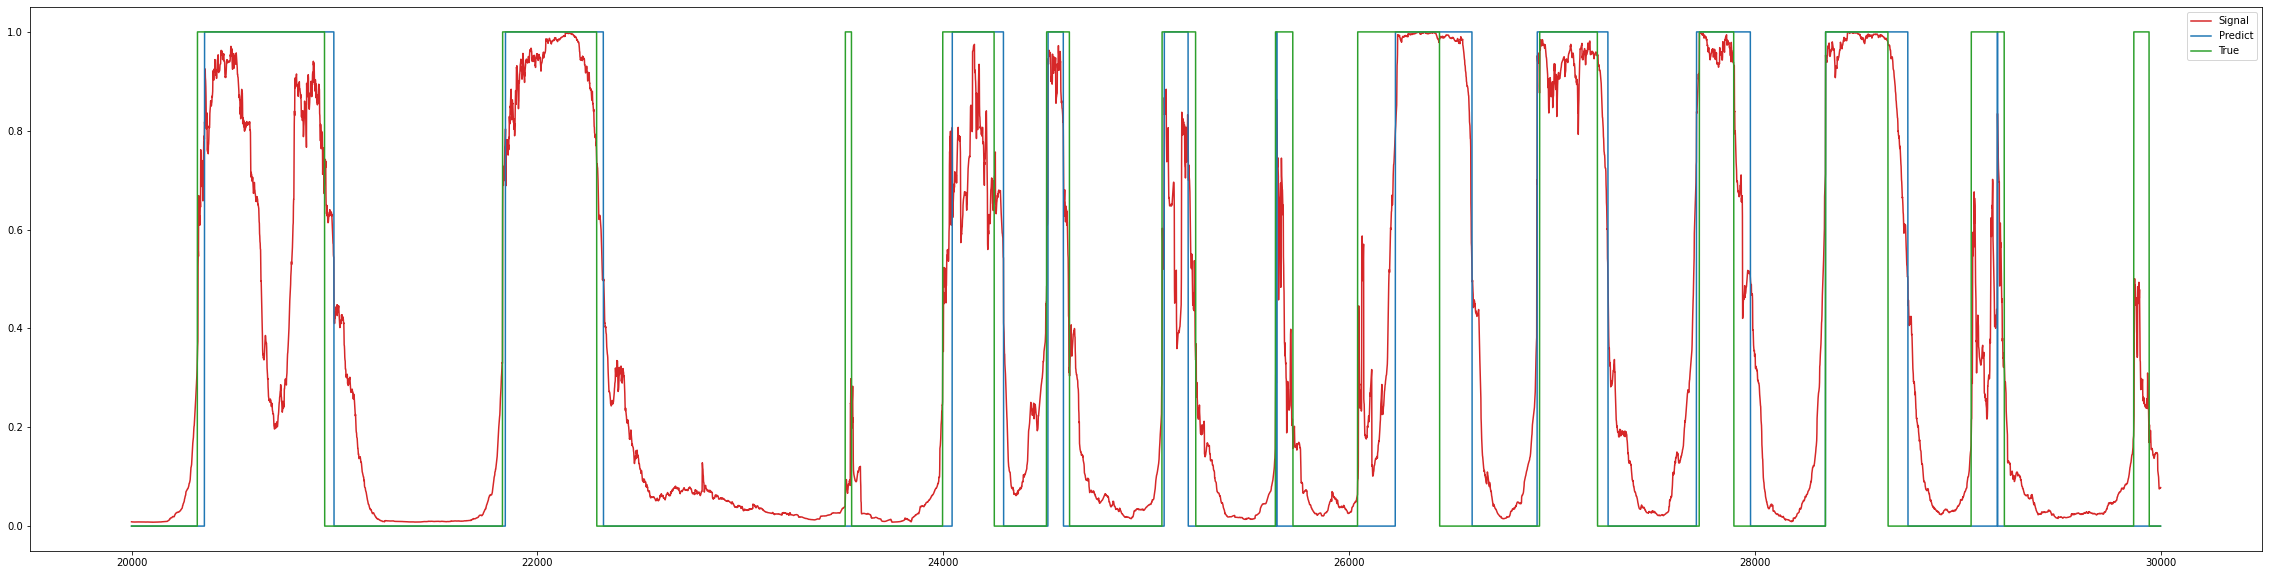

In [29]:
final_graph(20000, 30000, new_lr_origin, new_lr_sm_pred, new_true)

In [30]:
result(new_true, new_lr_sm_pred)

,result
AUC,0.883565
Accuracy,0.906872
Sensitivity,0.839547
Specificity,0.927584


### RandomForest

In [31]:
new_rf_sm_pred, new_rf_origin = random_forest(train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:23<00:00, 2842.26it/s]


In [32]:
new_turn_rf = total_turn_taking(new_rf_sm_pred, new_true)

In [33]:
result(new_true, new_rf_sm_pred)

,result
AUC,0.925151
Accuracy,0.933780
Sensitivity,0.908855
Specificity,0.941448


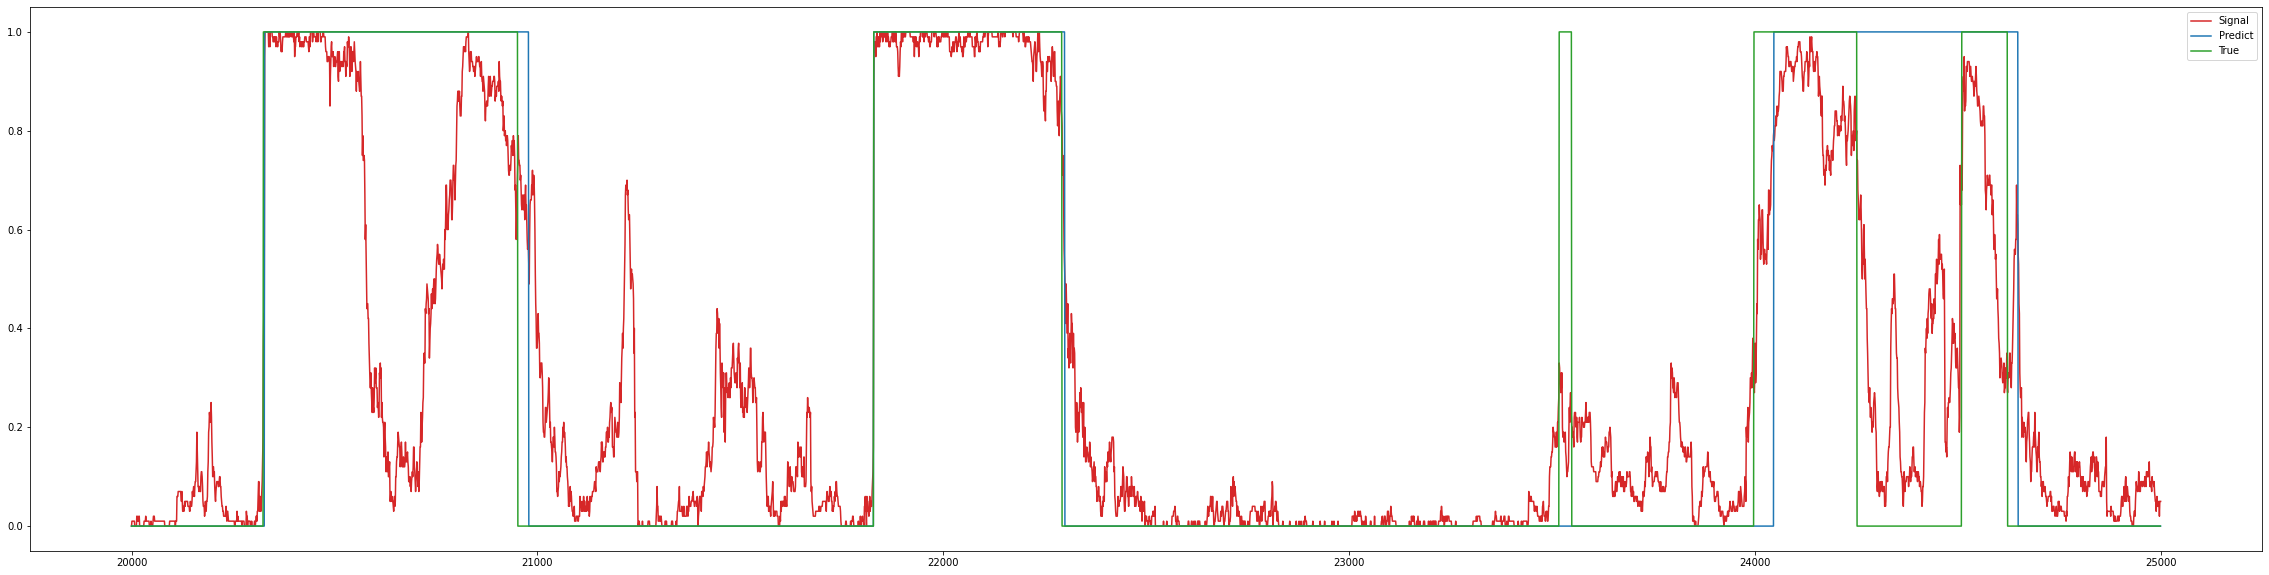

In [34]:
final_graph(20000, 25000, new_rf_origin, new_rf_sm_pred, new_true)

### Neural Network

In [49]:
new_nn_sm_pred, new_nn_origin = neural_network(train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:23<00:00, 2845.70it/s]


In [50]:
new_turn_nn = total_turn_taking(new_nn_sm_pred, new_true)
new_turn_nn

,turn_taking
train,37
true_test,45


In [51]:
result(new_true, new_nn_sm_pred)

,result
AUC,0.891213
Accuracy,0.933750
Sensitivity,0.810874
Specificity,0.971552


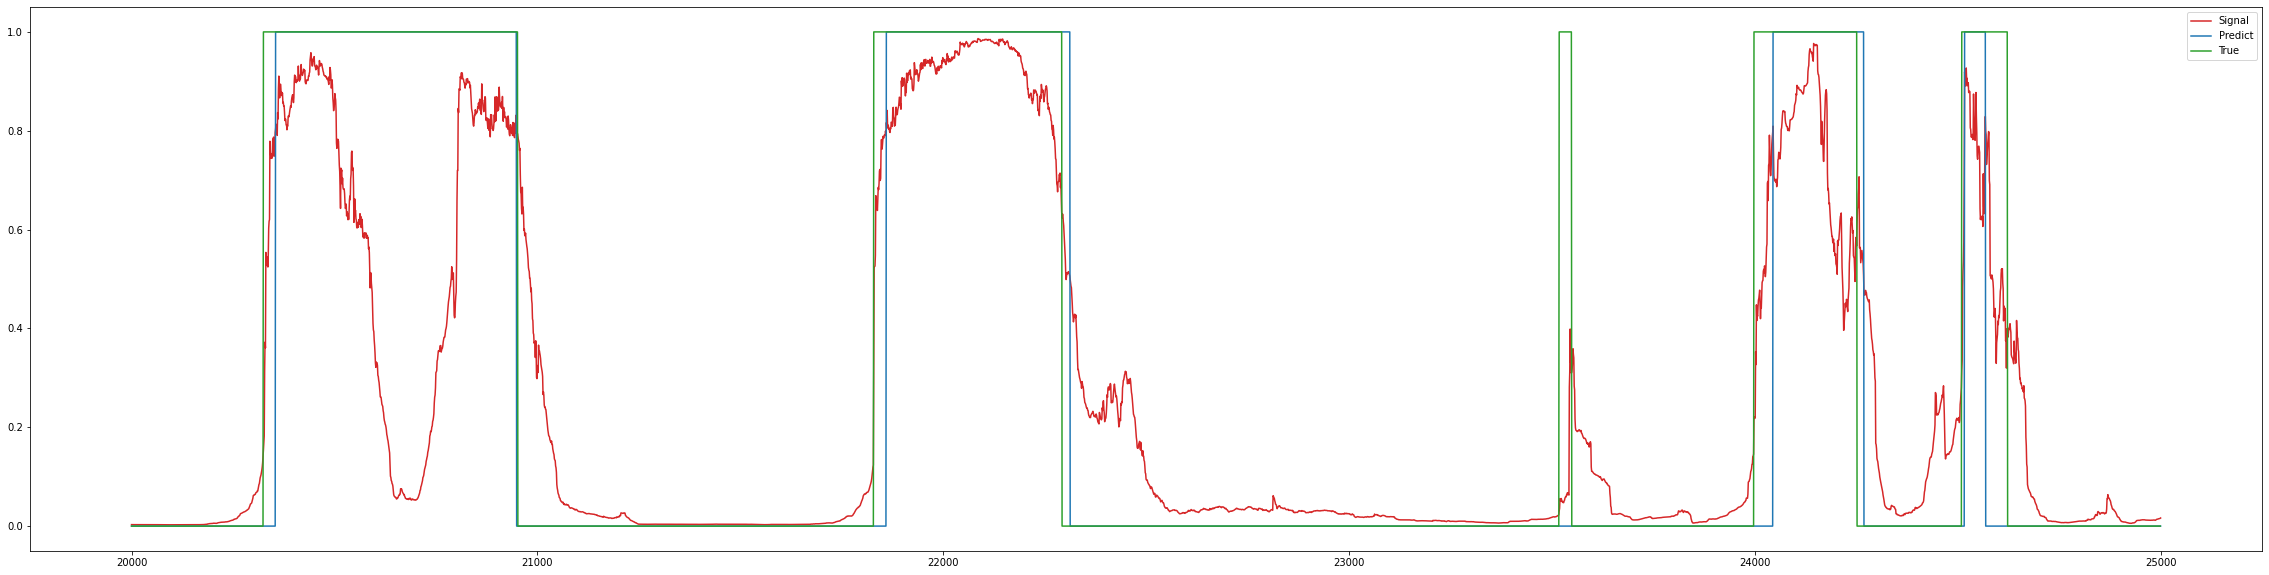

In [52]:
final_graph(20000, 25000, new_nn_origin, new_nn_sm_pred, new_true)

### Gradient Boosting

In [53]:
new_grb_sm_pred, new_grb_origin = gradient_boosting(train_tuple, new_test_x, mode="test")

100%|██████████| 67155/67155 [00:23<00:00, 2908.42it/s]


In [54]:
new_turn_grb = total_turn_taking(new_grb_sm_pred, new_true)
new_turn_grb

,turn_taking
train,36
true_test,45


In [55]:
result(new_true, new_grb_sm_pred)

,result
AUC,0.922048
Accuracy,0.942372
Sensitivity,0.883664
Specificity,0.960433


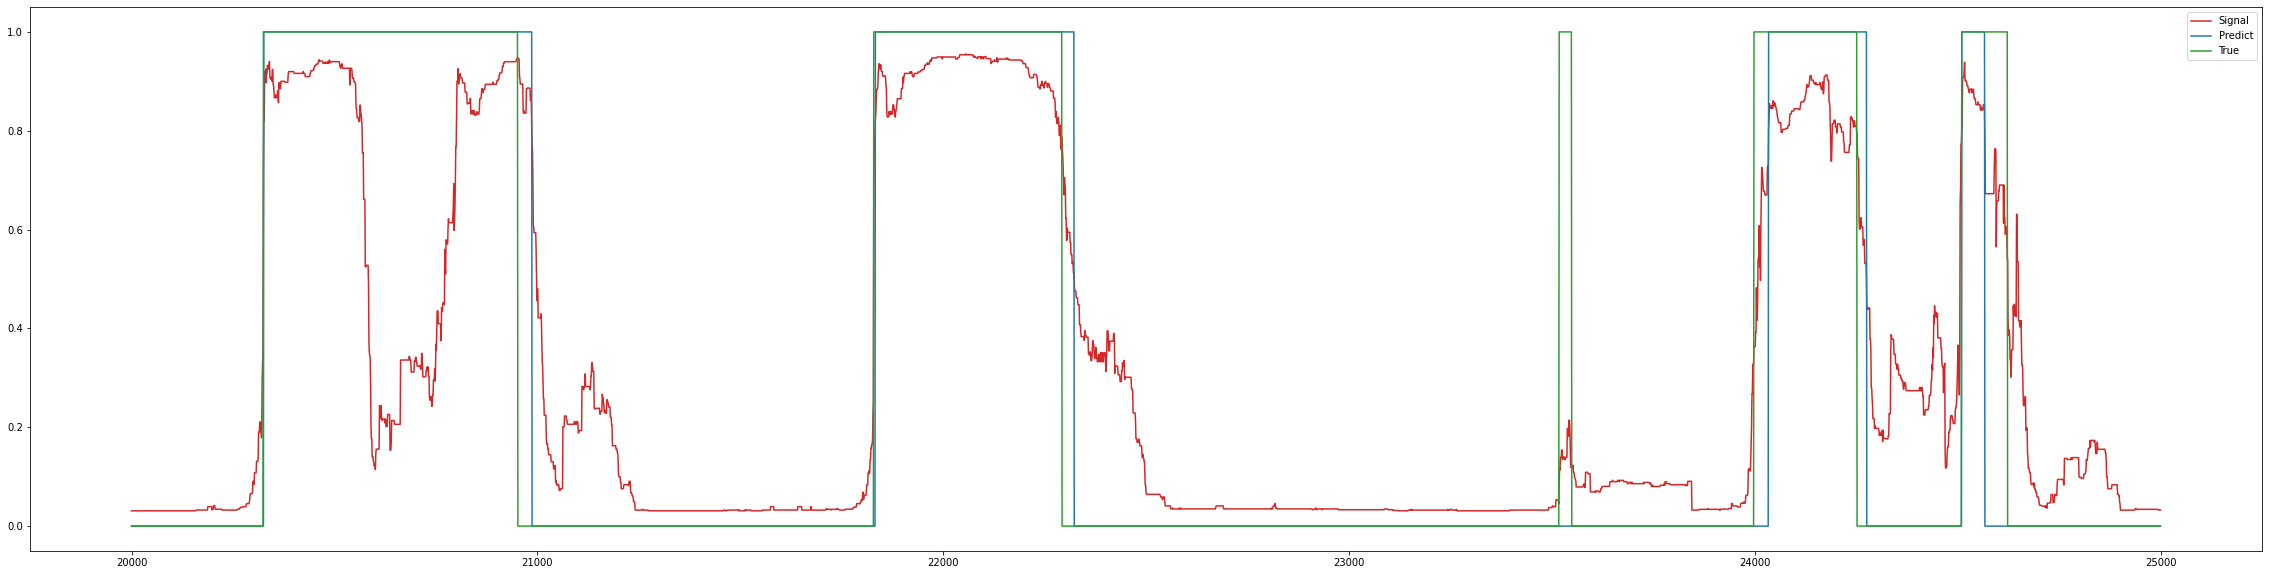

In [56]:
final_graph(20000, 25000, new_grb_origin, new_grb_sm_pred, new_true)

### LightGBM

In [43]:
new_lgb_sm_pred, new_lgb_origin = lightGBM(train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:23<00:00, 2840.24it/s]


In [44]:
new_turn_lgb = total_turn_taking(new_lgb_sm_pred, new_true)
new_turn_lgb

,turn_taking
train,37
true_test,45


In [45]:
result(new_true, new_lgb_sm_pred)

,result
AUC,0.929581
Accuracy,0.941226
Sensitivity,0.907589
Specificity,0.951573


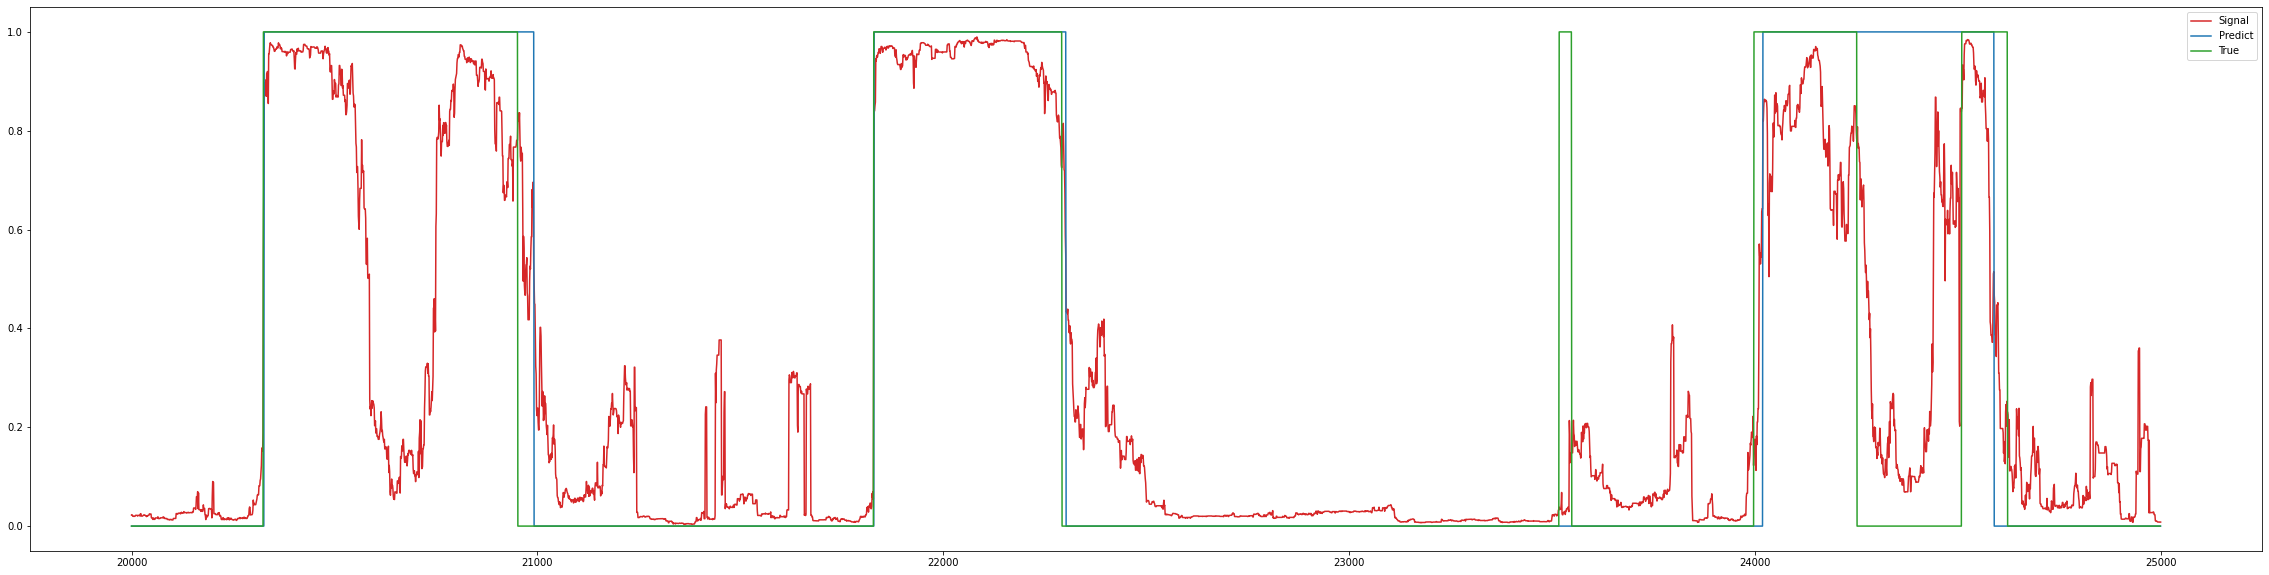

In [51]:
final_graph(20000, 25000, new_lgb_origin, new_lgb_sm_pred, new_true)

### Voting Classifier(lr, rf, nn, grb)

In [57]:
new_voting_sm_pred, new_voting_origin = voting_classifier(train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:24<00:00, 2760.08it/s]


In [58]:
new_turn_voting = total_turn_taking(new_voting_sm_pred, new_true)
new_turn_voting

,turn_taking
train,37
true_test,45


In [59]:
result(new_true, new_voting_sm_pred)

,result
AUC,0.909577
Accuracy,0.935329
Sensitivity,0.860941
Specificity,0.958213


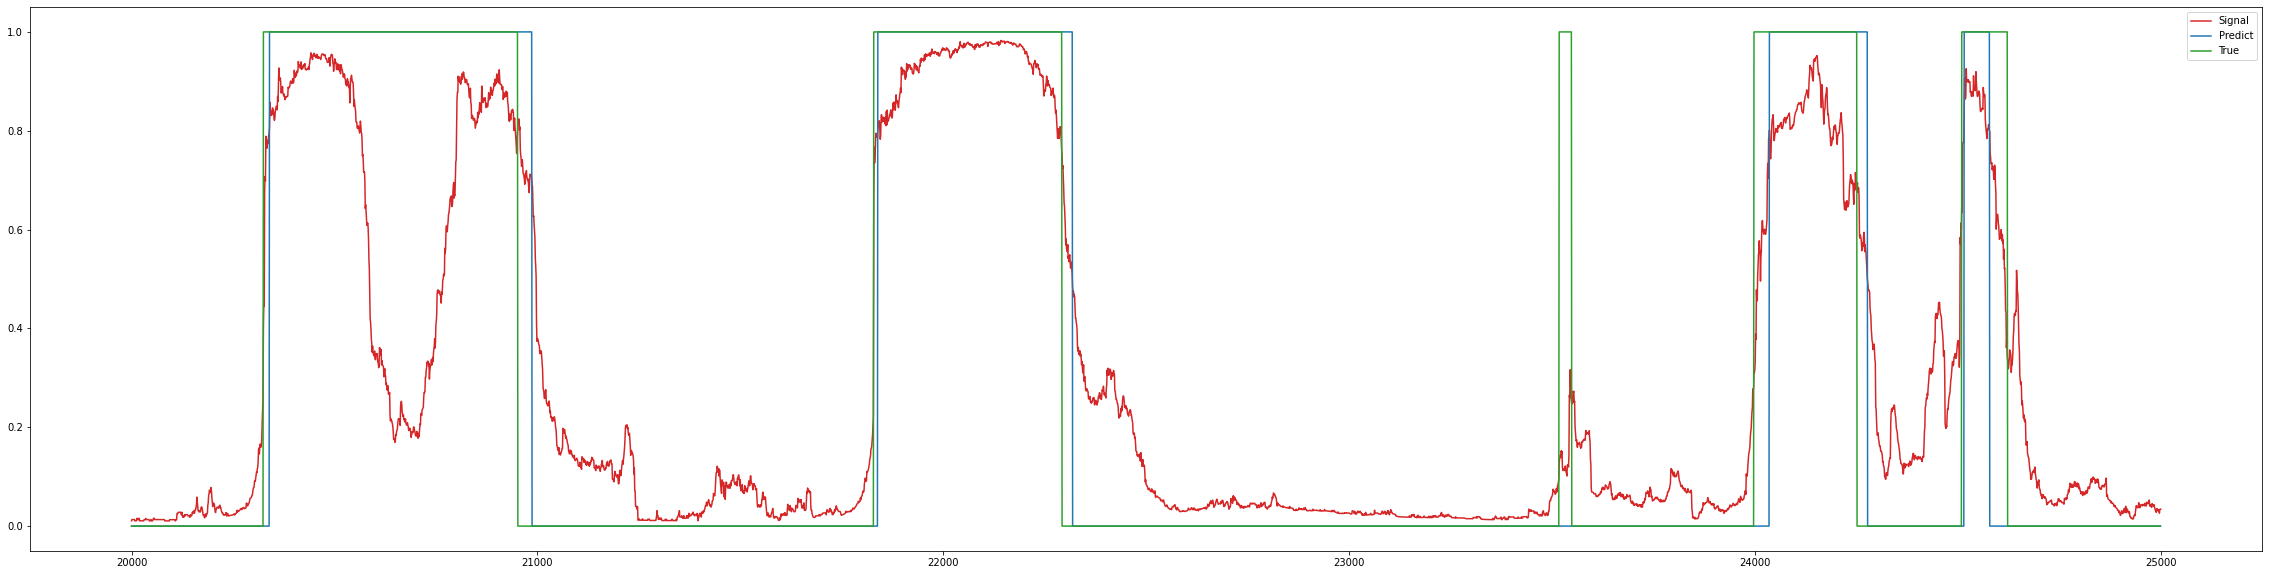

In [60]:
final_graph(20000, 25000, new_voting_origin, new_voting_sm_pred, new_true)